# Load data

In [1]:
import torchvision

dataset = torchvision.datasets.ImageFolder("/kaggle/input/cityscapes-pix2pix-dataset", transform=torchvision.transforms.ToTensor())

In [2]:
x_train, y_train = [], []
x_val, y_val = [], []

img_height= 256
img_width = 256

for data in dataset:
    if data[1] == 0:
        x_train.append(data[0][:,:,:256])
        y_train.append(data[0][:,:,256:])
    else:
        x_val.append(data[0][:,:,:256])
        y_val.append(data[0][:,:,256:])

print(f'x_train: {len(x_train)} x {x_train[0].shape}')
print(f'y_train: {len(y_train)} x {y_train[0].shape}')
print(f'x_val: {len(x_val)} x {x_val[0].shape}')
print(f'y_val: {len(y_val)} x {y_val[0].shape}')

x_train: 2975 x torch.Size([3, 256, 256])
y_train: 2975 x torch.Size([3, 256, 256])
x_val: 500 x torch.Size([3, 256, 256])
y_val: 500 x torch.Size([3, 256, 256])


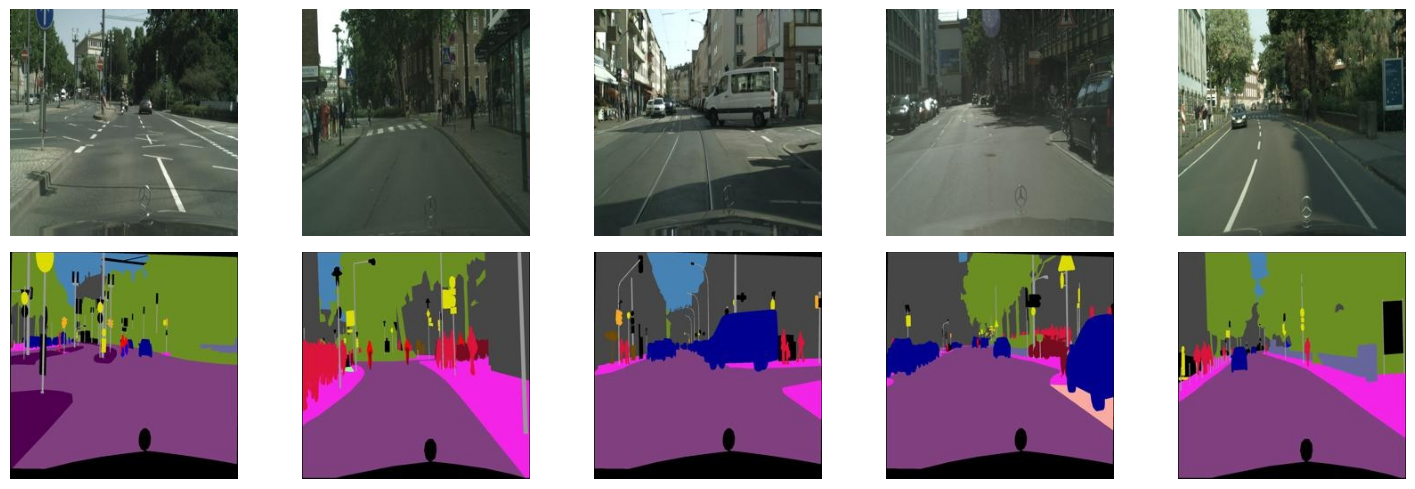

In [3]:
import torch
import matplotlib.pyplot as plt

n_sample = 5
samples_idx = [torch.randint(high=len(x_val), size=(1,)).item() for _ in range(n_sample)]

def plot_real_samples(samples_idx):
    plt.figure(figsize=(15,5))
    for i in range(len(samples_idx)):
        idx = samples_idx[i]
        x, y = x_val[idx], y_val[idx]
        plt.subplot(2, n_sample, i+1), plt.axis('off')
        plt.imshow(x.permute(1,2,0))
        plt.subplot(2, n_sample, i+n_sample+1), plt.axis('off')
        plt.imshow(y.permute(1,2,0))
    plt.tight_layout()
    plt.show()

plot_real_samples(samples_idx)

# Implementation

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import cat as cat


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


def apply_dropout_train(m):
    if type(m) == nn.Dropout:
        m.train()


def Ck(in_channels, out_channels, batch_norm=True, relu_slope=0.2, conv=nn.Conv2d, stride=2, padding=1):
    return nn.Sequential(
        conv(in_channels, out_channels, kernel_size=(4, 4), stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
        nn.LeakyReLU(0.2, True),
    )


def CDk(in_channels, out_channels, batch_norm=True, dropout=0.5, relu_slope=0.2, conv=nn.Conv2d, stride=2, padding=1):
    return nn.Sequential(
        conv(in_channels, out_channels, kernel_size=(4, 4), stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
        nn.Dropout(dropout),
        nn.LeakyReLU(relu_slope, True),
    )


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        # 286 × 286 discriminator: C64-C128-C256-C512-C512-C512
        self.layers = nn.Sequential(
            Ck(in_channels * 2, 64, batch_norm=False),
            Ck(64, 128),
            Ck(128, 256),
            Ck(256, 512),
            Ck(512, 512),
            Ck(512, 512),
        )
        self.final = nn.Sequential(
            nn.Conv2d(512, 1, (4,4), stride=2),
            nn.Flatten(),
            nn.Sigmoid(),
        )
        self.apply(weights_init_normal)


    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        x = self.layers(img_input)
        return self.final(x)


    def eval(self):
        super().eval()
        self.apply(apply_dropout_train)


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        # encoder: C64-C128-C256-C512-C512-C512-C512-C512
        self.down1 = Ck(in_channels, 64, batch_norm=False)
        self.down2 = Ck(64, 128)
        self.down3 = Ck(128, 256)
        self.down4 = Ck(256, 512)
        self.down5 = Ck(512, 512)
        self.down7 = Ck(512, 512)
        self.down8 = Ck(512, 512, stride=1, padding=0, batch_norm=False)

        # decoder: CD512-CD512-CD512-C512-C256-C128-C64
        self.up1 = CDk(512, 512, conv=nn.ConvTranspose2d, relu_slope=0, padding=0)
        self.up2 = CDk(1024, 512, conv=nn.ConvTranspose2d, relu_slope=0)
        self.up4 = CDk(1024, 512, conv=nn.ConvTranspose2d, relu_slope=0)
        self.up5 = CDk(1024, 256, conv=nn.ConvTranspose2d, relu_slope=0)
        self.up6 = CDk(512, 128, conv=nn.ConvTranspose2d, relu_slope=0)
        self.up7 = CDk(256, 64, conv=nn.ConvTranspose2d, relu_slope=0)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, (4,4), stride=2, padding=1),
            nn.Tanh(),
        )
        self.apply(weights_init_normal)


    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d7 = self.down7(d5)
        d8 = self.down8(d7)
        u1 = cat((self.up1(d8), d7), 1)
        u2 = cat((self.up2(u1), d5), 1)
        u4 = cat((self.up4(u2), d4), 1)
        u5 = cat((self.up5(u4), d3), 1)
        u6 = cat((self.up6(u5), d2), 1)
        u7 = cat((self.up7(u6), d1), 1)
        return self.final(u7)


    def eval(self):
        super().eval()
        self.apply(apply_dropout_train)



# Training

In [5]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])


train_dataset = MyDataset(x_train, y_train)
val_dataset = MyDataset(x_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
from torch.autograd import Variable
import numpy as np

patch = (1, img_height // 2 ** 4, img_width // 2 ** 4)
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = GeneratorUNet().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

lambda_pixel = 100
n_epochs = 50

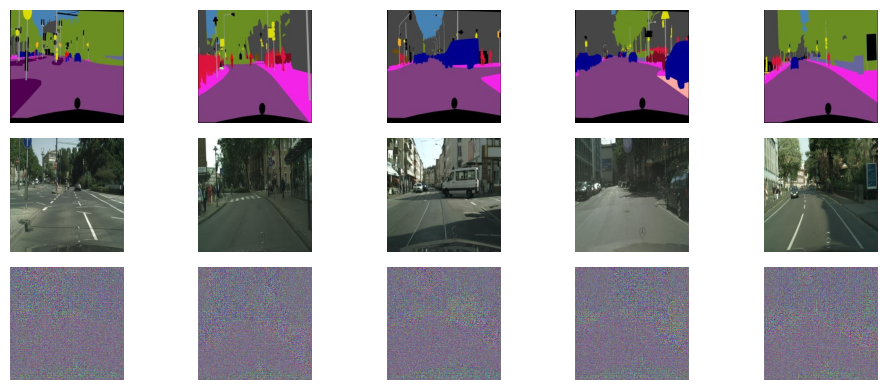

Validate [1/50]: 100%|██████████| 16/16 [00:02<00:00,  6.11it/s, loss_G:14.50686, loss_D:0.32497]


Validate [2/50]: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s, loss_G:18.33527, loss_D:0.12672]


Validate [3/50]: 100%|██████████| 16/16 [00:02<00:00,  6.14it/s, loss_G:14.94159, loss_D:0.05952]


Validate [4/50]: 100%|██████████| 16/16 [00:02<00:00,  6.19it/s, loss_G:14.37705, loss_D:0.01200]


Validate [5/50]: 100%|██████████| 16/16 [00:02<00:00,  6.19it/s, loss_G:14.58994, loss_D:0.00274]


Validate [6/50]: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss_G:14.60535, loss_D:0.00242]


Validate [7/50]: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss_G:14.17502, loss_D:0.02480]


Validate [8/50]: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s, loss_G:14.02419, loss_D:0.20016]


Validate [9/50]: 100%|██████████| 16/16 [00:02<00:00,  6.21it/s, loss_G:14.77222, loss_D:0.08905]


Validate [10/50]: 100%|██████████| 16/16 [00:02<00:00,  6.27it/s, loss_G:14.24486, loss_D:0.15273]


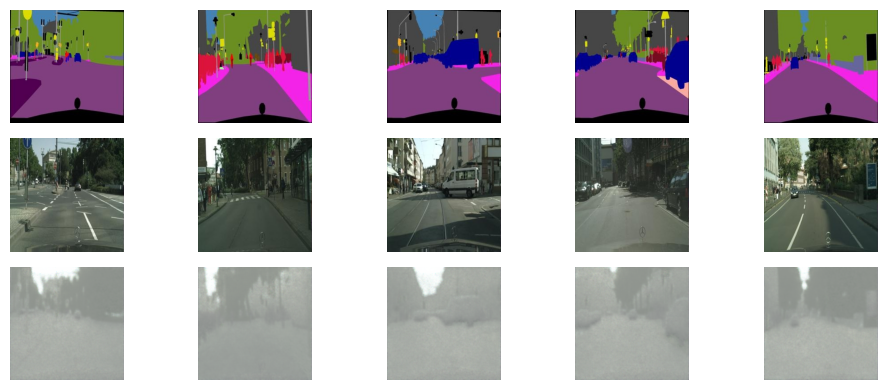

Validate [11/50]: 100%|██████████| 16/16 [00:02<00:00,  5.95it/s, loss_G:13.55931, loss_D:0.50000]


Validate [12/50]: 100%|██████████| 16/16 [00:02<00:00,  6.20it/s, loss_G:13.16742, loss_D:0.50000]


Validate [13/50]: 100%|██████████| 16/16 [00:02<00:00,  6.09it/s, loss_G:13.01540, loss_D:0.50000]


Validate [14/50]: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s, loss_G:12.86334, loss_D:0.50000]


Validate [15/50]: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss_G:13.90069, loss_D:0.33898]


Validate [16/50]: 100%|██████████| 16/16 [00:02<00:00,  6.15it/s, loss_G:14.05277, loss_D:0.13596]


Validate [17/50]: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s, loss_G:14.12008, loss_D:0.09968]


Validate [18/50]: 100%|██████████| 16/16 [00:02<00:00,  6.10it/s, loss_G:14.24284, loss_D:0.15190]


Validate [19/50]: 100%|██████████| 16/16 [00:02<00:00,  6.26it/s, loss_G:13.83492, loss_D:0.09819]


Validate [20/50]: 100%|██████████| 16/16 [00:02<00:00,  6.12it/s, loss_G:14.08516, loss_D:0.10442]


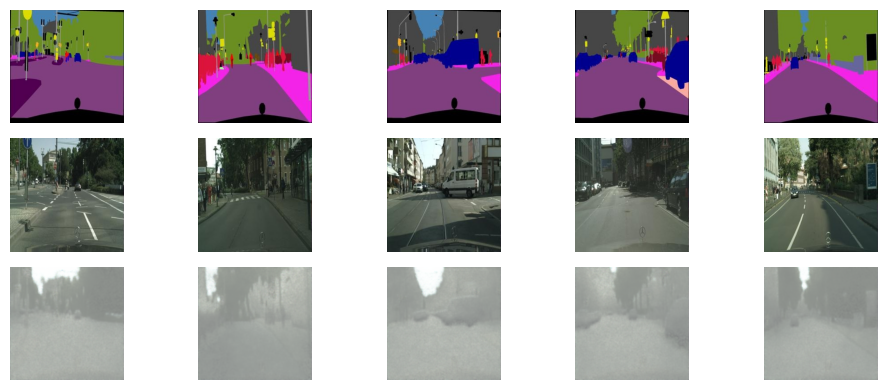

Validate [21/50]: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss_G:13.92863, loss_D:0.12496]


Validate [22/50]: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss_G:14.09422, loss_D:0.17113]


Validate [23/50]: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss_G:14.15232, loss_D:0.13967]


Validate [24/50]: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss_G:14.21648, loss_D:0.14219]


Validate [25/50]: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss_G:13.99880, loss_D:0.13617]


Validate [26/50]: 100%|██████████| 16/16 [00:02<00:00,  6.30it/s, loss_G:14.31483, loss_D:0.15176]


Validate [27/50]: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss_G:13.93015, loss_D:0.14193]


Validate [28/50]: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s, loss_G:14.01337, loss_D:0.27266]


Validate [29/50]: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss_G:13.88963, loss_D:0.24593]


Validate [30/50]: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss_G:13.98568, loss_D:0.06949]


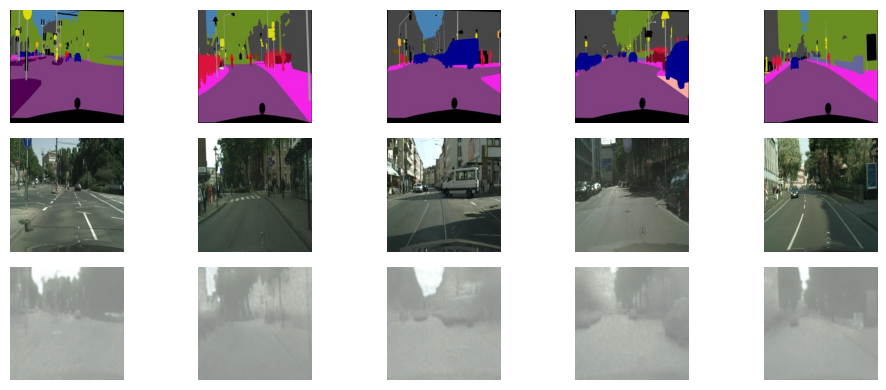

Validate [31/50]: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s, loss_G:13.20085, loss_D:0.46874]


Validate [32/50]: 100%|██████████| 16/16 [00:02<00:00,  6.22it/s, loss_G:14.90330, loss_D:0.50000]


Validate [33/50]: 100%|██████████| 16/16 [00:02<00:00,  6.22it/s, loss_G:14.09463, loss_D:0.07757]


Validate [34/50]: 100%|██████████| 16/16 [00:02<00:00,  6.32it/s, loss_G:14.01432, loss_D:0.02677]


Validate [35/50]: 100%|██████████| 16/16 [00:02<00:00,  6.28it/s, loss_G:14.20504, loss_D:0.16409]


Validate [36/50]: 100%|██████████| 16/16 [00:02<00:00,  6.23it/s, loss_G:14.15779, loss_D:0.10584]


Validate [37/50]: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss_G:14.38359, loss_D:0.10638]


Validate [38/50]: 100%|██████████| 16/16 [00:02<00:00,  6.25it/s, loss_G:14.41763, loss_D:0.08065]


Validate [39/50]: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s, loss_G:14.28102, loss_D:0.12883]


Validate [40/50]: 100%|██████████| 16/16 [00:02<00:00,  6.34it/s, loss_G:14.39289, loss_D:0.10478]


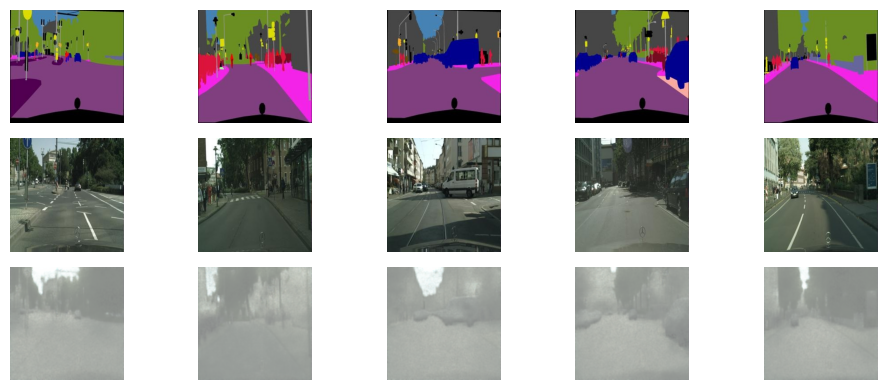

Validate [41/50]: 100%|██████████| 16/16 [00:02<00:00,  6.05it/s, loss_G:14.37005, loss_D:0.09516]


Validate [42/50]: 100%|██████████| 16/16 [00:02<00:00,  6.19it/s, loss_G:14.33609, loss_D:0.10456]


Validate [43/50]: 100%|██████████| 16/16 [00:02<00:00,  6.19it/s, loss_G:14.25860, loss_D:0.09700]


Validate [44/50]: 100%|██████████| 16/16 [00:02<00:00,  6.19it/s, loss_G:14.34191, loss_D:0.09536]


Validate [45/50]: 100%|██████████| 16/16 [00:02<00:00,  6.16it/s, loss_G:14.40126, loss_D:0.08503]


Validate [46/50]: 100%|██████████| 16/16 [00:02<00:00,  6.11it/s, loss_G:14.41245, loss_D:0.06638]


Validate [47/50]: 100%|██████████| 16/16 [00:02<00:00,  6.09it/s, loss_G:14.21349, loss_D:0.07923]


Validate [48/50]: 100%|██████████| 16/16 [00:02<00:00,  6.09it/s, loss_G:14.09843, loss_D:0.06443]


Validate [49/50]: 100%|██████████| 16/16 [00:02<00:00,  6.14it/s, loss_G:14.28502, loss_D:0.06512]


Validate [50/50]: 100%|██████████| 16/16 [00:02<00:00,  6.17it/s, loss_G:14.48459, loss_D:0.06166]


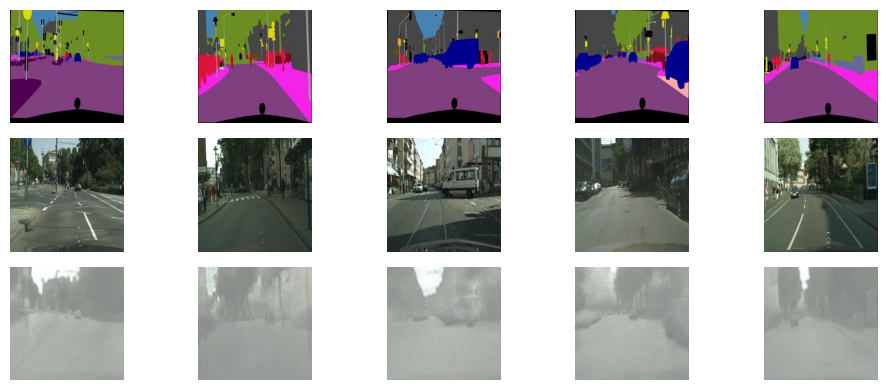

In [7]:
from tqdm import tqdm


def plot_generated_samples(samples_idx, generator, title):
    plt.figure(figsize=(10,4))
    for i in range(len(samples_idx)):
        idx = samples_idx[i]
        x = x_val[idx].to(device)
        y = y_val[idx].to(device)
        x_fake = generator(y[None,:,:,:])[0]
        x_fake = ((x_fake + 1) / 2)

        plt.subplot(3, n_sample, i+1), plt.axis('off')
        plt.imshow(y.detach().cpu().permute(1,2,0))

        plt.subplot(3, n_sample, i+n_sample+1), plt.axis('off')
        plt.imshow(x.detach().cpu().permute(1,2,0))

        plt.subplot(3, n_sample, i+2*n_sample+1), plt.axis('off')
        plt.imshow(x_fake.detach().cpu().permute(1,2,0))

    plt.tight_layout()
    plt.show()



def run_epoch(mode, dataloader, bar_desc='', display_bar=True):
    if mode=='train':
        generator.train()
        discriminator.train()

    elif mode=='validate':
        generator.eval()
        discriminator.eval()

    else:
        raise 'Unexpected mode'

    if display_bar:
        bar = tqdm(total=len(dataloader), desc=bar_desc, postfix='', leave=True, position=0)

    sum_loss_D, sum_loss_G = 0, 0
    for batch_i, (x,y) in enumerate(dataloader):
        x = x.to(device) # real_B
        y = y.to(device) # real_A

        valid = Variable(torch.FloatTensor(np.ones((x.size(0), 1))), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(np.zeros((x.size(0), 1))), requires_grad=False).to(device)

        # __________ Train Generator y-->x __________
        if mode=='train': optimizer_G.zero_grad()

        x_fake = generator(y)
        pred_fake = discriminator(x_fake, y)

        loss_GAN = criterion_GAN(pred_fake, valid)
        loss_pixel = criterion_pixelwise(x_fake, x)

        loss_G = loss_GAN + lambda_pixel * loss_pixel
        sum_loss_G += loss_G.item()

        if mode=='train':
            loss_G.backward()
            optimizer_G.step()

        # __________ Train Discriminator __________
        if mode=='train': optimizer_D.zero_grad()

        pred_real = discriminator(x, y)
        loss_real = criterion_GAN(pred_real, valid)

        pred_fake = discriminator(x_fake.detach(), y)
        loss_fake = criterion_GAN(pred_fake, fake)

        loss_D = 0.5 * (loss_real + loss_fake)
        sum_loss_D += loss_D.item()

        if mode=='train':
            loss_D.backward()
            optimizer_D.step()

        if display_bar:
            bar.set_postfix_str(f'loss_G:{loss_G.item():.5f}, loss_D:{loss_D.item():.5f}')
            bar.update(1)

    return sum_loss_D/len(dataloader), sum_loss_G/len(dataloader)


results = []
plot_generated_samples(samples_idx, generator, f'Generated sample before start')

for epoch in range(n_epochs):
    res = run_epoch('train', train_loader, bar_desc= f'Training [{epoch+1}/{n_epochs}]')
    results.append(res)

    res = run_epoch('validate', val_loader, bar_desc=f'Validate [{epoch+1}/{n_epochs}]')
    results.append(res)
    print()

    if (epoch+1) % 10 == 0:
        plot_generated_samples(samples_idx, generator, f'Generated sample epoch[{epoch+1}]')
        torch.save(generator.state_dict(), f'generator_epoch{epoch+1}.pkl')
        torch.save(discriminator.state_dict(), f'discriminator_epoch{epoch+1}.pkl')

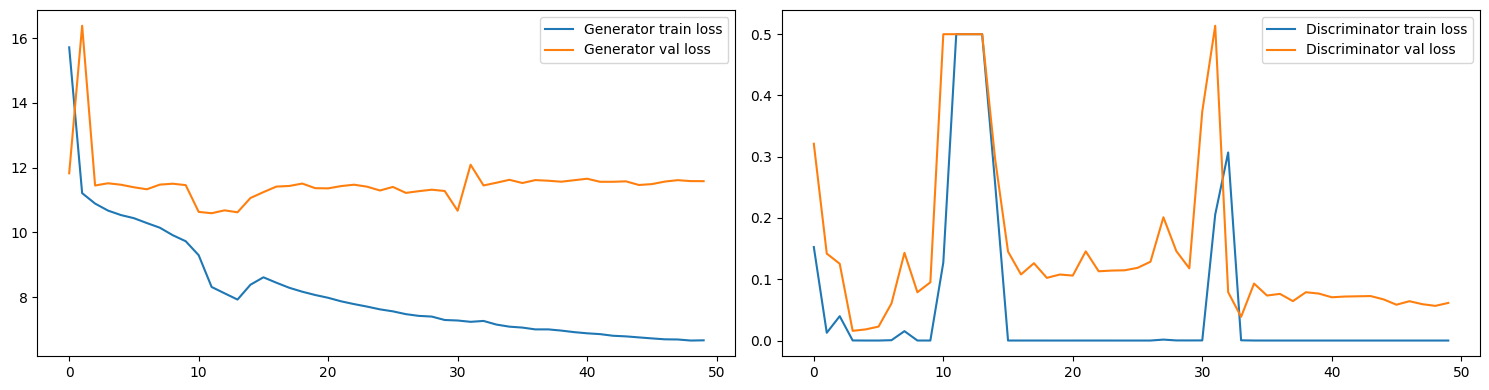

In [8]:
train_losses_G, val_losses_G = [], []
train_losses_D, val_losses_D = [], []

for i in range(len(results) // 2):
    train_losses_G.append(results[2*i][1])
    train_losses_D.append(results[2*i][0])
    val_losses_G.append(results[2*i+1][1])
    val_losses_D.append(results[2*i+1][0])

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses_G, label='Generator train loss')
plt.plot(val_losses_G, label='Generator val loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses_D, label='Discriminator train loss')
plt.plot(val_losses_D, label='Discriminator val loss')
plt.legend()

plt.tight_layout()
plt.show()